In [102]:
%matplotlib notebook
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
from sklearn.feature_extraction import DictVectorizer  # 可转换成multi-hot
import os
import datatable as dt
import pandas as pd
import numpy as np
# 利用tf、idf学习文本特征，再用LDA模型学习低维表示
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA, PCA, NMF, FastICA, KernelPCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import ParameterGrid

In [87]:
def vectorizer_doc(corpus, method='tfidf', max_df=.95, min_df=8, n_features=1000):
    if method == 'tfidf':
        vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df, max_features=n_features)
    elif method == 'tf':
        vectorizer = CountVectorizer(max_df=max_df, min_df=min_df, max_features=n_features)
    
    feat = vectorizer.fit_transform(corpus)
    
    return feat



def reduction(data, n_components=10, method='LDA', random_state=0, **kwargs):
    if method == 'LDA':
        reducer = LDA(n_components=n_components, max_iter=5, learning_method='online', learning_offset=50., random_state=random_state)
    elif method == 'PCA':
        reducer = PCA(n_components=n_components, random_state=random_state)
    elif method == 'KPCA':
        kernel = kwargs.get('kernel', 'rbf')
        gamma = kwargs.get('gamma', None)
        reducer = KernelPCA(n_components=n_components, kernel=kernel, gamma=gamma, random_state=random_state)
    elif method == 'NMF':
        init = kwargs.get('init', 'random')
        reducer = NMF(n_components=n_components, init=init, random_state=random_state)
    elif method == 'ICA':
        reducer = FastICA(n_components=n_components, random_state=random_state)
    elif method == 'TSNE':
        reducer = TSNE(n_components=n_components)
    else:
        raise ValueError(f"Not Suportted Method : {method}")
        
    return reducer.fit_transform(data)

In [5]:
base_dir = "./2021_3_data"
test_data_dir  = os.path.join(base_dir, "testdata")
train_data_dir = os.path.join(base_dir, "traindata")

train_dirs = os.listdir(train_data_dir)
test_dirs  = os.listdir(test_data_dir)
print(train_dirs,'\n', test_dirs)

['history_behavior_data', 'user_features_data', 'video_features_data'] 
 ['test.csv']


In [11]:
video_df = pd.read_csv(os.path.join(train_data_dir, 'video_features_data/video_features_data.csv'), delimiter='\t')

In [24]:
video_df['video_tags'] = video_df['video_tags'].astype(str)

In [71]:
desc_corpus = video_df['video_tags'].apply(lambda x: ' '.join(x.split(',')))

In [81]:
vec_params = {'method': ['tf', 'tfidf'], 'n_features': list(range(500, 1500, 200))}
red_params = {'method': ['PCA', 'LDA', 'KPCA', 'NMF', 'ICA', 'TSNE'], 'n_components': list(range(5, 20, 2)), 'random_state': [0, 1, 2, 3]}

all_vec_params = list(ParameterGrid(vec_params))
all_red_params = list(ParameterGrid(red_params))

In [ ]:
%%time
cs = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
ms = ['3', 'P', 'x', '^', '+', 'o', 'v', 's', 'd', '>', 'D', '<', '*', 'X']
# c_mapping = dict(zip(list(range(n_clusters)), cs[:n_clusters])) 
# m_mapping = dict(zip(list(range(n_clusters)), ms[:n_clusters])) 
for vp in all_vec_params:
    print(f"start {vp}")
    veced = vectorizer_doc(desc_corpus, method=vp['method'], n_features=vp['n_features']).toarray()
    print(f"\t veced")
    for rp in all_red_params:
        print(f"\t start {rp}")
        reded = reduction(veced, n_components=rp['n_components'], method=rp['method'], random_state=rp['random_state'])
        print(f"\t reduced")
        rreded = reduction(r_vdoc, n_components=2, method='TSNE')
        print(f"\t TSNEed")
        n_clusters = rp['n_components']
        cluster = KMeans(n_clusters=n_clusters, random_state=0)
        cluster.fit(reded)
        labels = cluster.labels_
        
        fig = plt.Figure(figsize=(12, 12))
        ax = fig.subplots()
        
        c_mapping = dict(zip(list(range(n_clusters)), cs[:n_clusters])) 
        m_mapping = dict(zip(list(range(n_clusters)), ms[:n_clusters])) 
        
        colors = list(map(lambda x: c_mapping[x], labels))
        markers = list(map(lambda x: m_mapping[x], labels))
        for l in range(n_clusters):
            ax.scatter(x=rreded[labels==l, 0], y=rreded[labels==l, 1], c=c_mapping[l], marker=m_mapping[l], s=2)
#         ax.scatter(x=rreded[:, 0], y=rreded[:, 1], c=colors, marker=markers, s=2)
        
        vps = ', '.join([f'{k}={v}' for k, v in vp.items()])
        rps = ', '.join([f'{k}={v}' for k, v in rp.items()])
        ax.set_title(f'VP[{vps}] RP[{rps}]')
        
        fig.savefig(f"VP[{vps}]-RP[{rps}].png", dpi=400)
        print(f'{vps}\t{rps} processed ...')
        fig

start {'method': 'tf', 'n_features': 500, 'random_state': 0}
	 veced
	 start {'method': 'PCA', 'n_components': 5, 'random_state': 0}
	 reduced


In [33]:
v_doc = vectorizer_doc(desc_corpus, method='tf', n_features=100).toarray()

In [41]:
r_vdoc = reduction(v_doc, n_components=10, method='LDA', random_state=0)

In [45]:
r_rvdoc = reduction(r_vdoc, n_components=2, method='TSNE')

In [54]:
n_clusters = 5
cluster = KMeans(n_clusters=n_clusters, random_state=0)
cluster.fit(r_vdoc)

KMeans(n_clusters=5, random_state=0)

In [55]:
labels = cluster.labels_

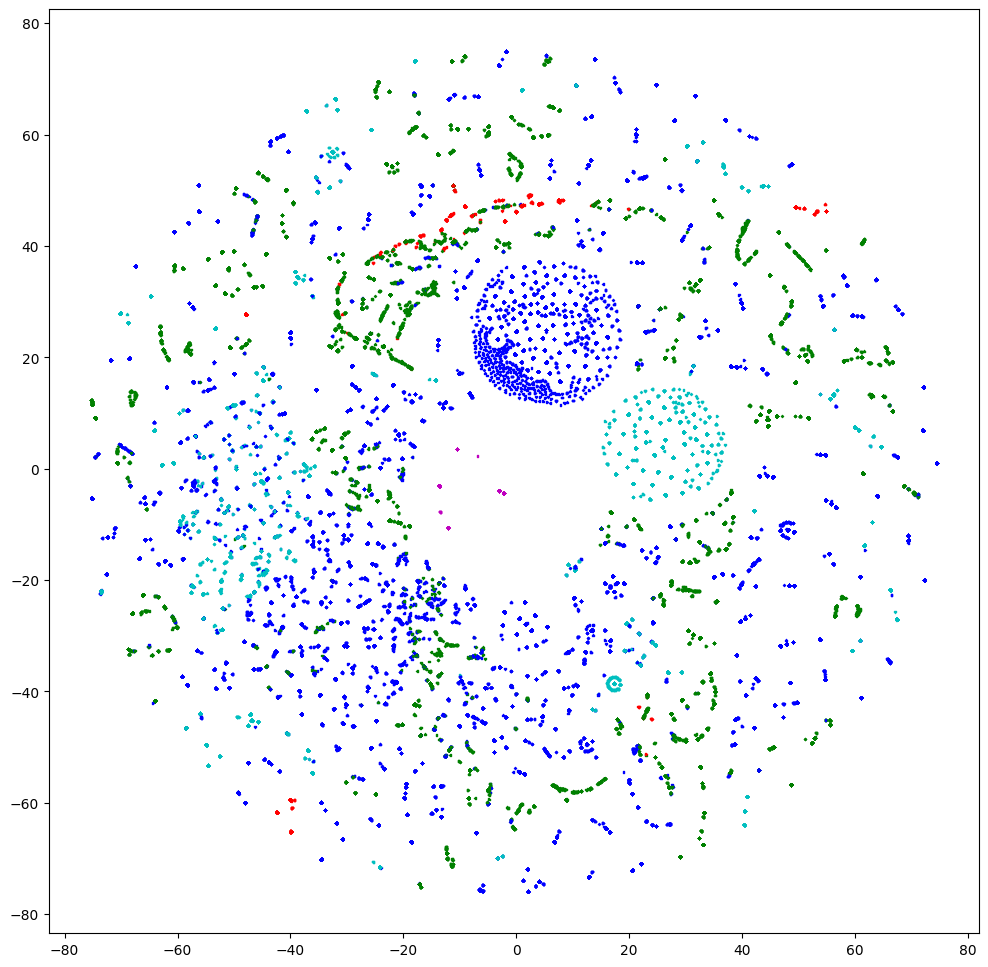

In [92]:
fig = plt.Figure(figsize=(12, 12))
ax = fig.subplots()
cs = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
mapping = dict(zip(list(range(n_clusters)), cs[:n_clusters])) 
colors = list(map(lambda x: mapping[x], labels))
ax.scatter(x=r_rvdoc[:, 0], y=r_rvdoc[:, 1], c=colors, marker='P', s=2)

fig